In [103]:
import os
import sys
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from matplotlib.patches import Patch
warnings.filterwarnings('ignore')
pplt.rc.update({'fontsize':12,'reso':'xx-hi','figure.dpi':100})

In [104]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'test'   

In [105]:
def get_r2(ytrue,ypred,dims=None):
    dims  = list(ytrue.dims) if dims is None else dims
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [106]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()
    
results = []
for model in MODELS:
    name,desc = model['name'],model['description']
    filepath  = os.path.join(PREDSDIR,f'{name}_{SPLIT}_predictions.nc')
    if not os.path.exists(filepath):
        continue
    with xr.open_dataset(filepath,engine='h5netcdf') as ds:
        ypred = ds.pr.load()
    ytrue,ypred = xr.align(truepr,ypred,join='inner')
    r2     = get_r2(ytrue,ypred,dims=None)
    r2mean = float(r2.mean('seed'))
    r2std  = float(r2.std('seed'))
    color  = ('yellow4' if ('kernel' in name and 'nonparametric' in name) 
              else 'red4' if ('kernel' in name) else 'blue4')
    results.append((name,desc,r2mean,r2std,color))

print(f'Found {len(results)} models with predictions!')

Found 10 models with predictions!


In [107]:
results.sort(key=lambda x:x[2])
labels = [item[1] for item in results]
means  = [item[2] for item in results]
stds   = [item[3] for item in results]
colors = [item[4] for item in results]

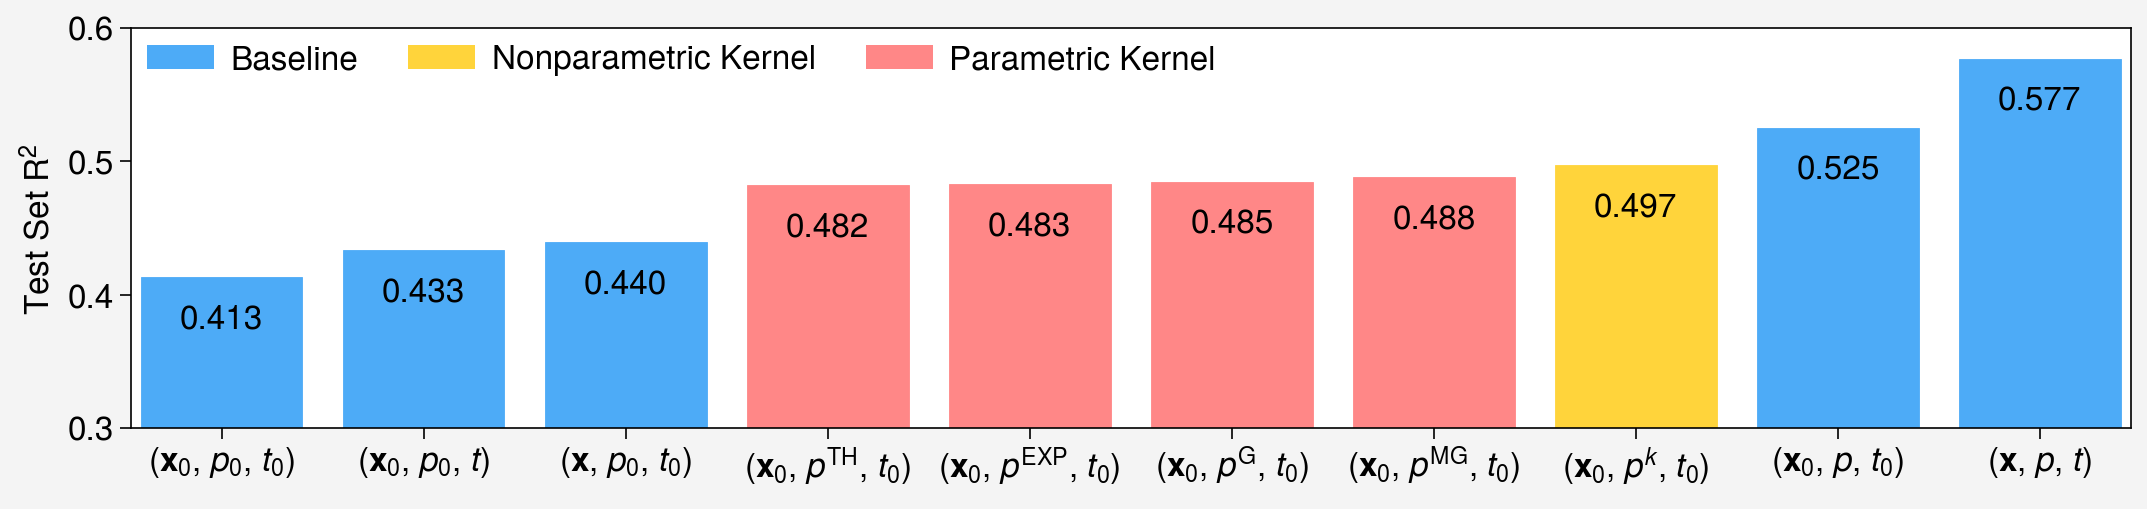

In [108]:
fig,ax = pplt.subplots(refwidth=10,refheight=2)
ax.format(ylabel='Test Set R$^2$',ylim=(0.3,0.6),yticks=0.1,yminorticks='none',grid=False)
# bars = ax.bar(labels,means,yerr=stds,color=colors,capsize=3)
bars = ax.bar(labels,means,color=colors)
for bar,mean,std in zip(bars,means,stds):
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height()-0.02,f'{mean:.3f}',ha='center',va='top')
elements = [Patch(facecolor='blue4',label='Baseline'),
            Patch(facecolor='yellow4',label='Nonparametric Kernel'),
            Patch(facecolor='red4',label='Parametric Kernel')]
ax.legend(handles=elements,loc='ul',ncols=3,frameon=False)
pplt.show()
fig.save('../figs/bars.png')